# **Bilan année 2021 des morts dans les bases de données Eudravigilance**

**Objectif** :
Analyser les chiffres de l'organisme de pharmacovigilance européen Eudravigilance afin de faire la somme du nombre de personnes ayant été supprimées de la base et le nombre de personnes ayant été rajoutées. Puis comparer ces données avec le nombre de doses pour 100 000 habitants injectés.

**Sources** : 

Base de données européenne des rapports sur les effets indésirables suspectés des médicaments :
https://www.adrreports.eu/

Covid-19 Vaccine Tracker :
https://vaccinetracker.ecdc.europa.eu/public/extensions/COVID-19/vaccine-tracker.html#distribution-tab

## **Dépendances**

In [1]:
from IPython.display import Markdown as md
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

import csv

## **Variables**

In [2]:
year = "2021"
dates = ['1er août', '14 septembre', '1er octobre', '14 octobre', '1er novembre', '14 novembre', '1er décembre', '14 décembre', '31 décembre']
dates_english = ['august 1st', 'september 14th', 'october 1st', 'october 14th', 'november 1st', 'november 14th', 'december 1st', 'december 14th', 'december 31th']
logs = []

In [3]:
list_dates = []
list_months = []

list_dates.append('1er')
list_months.append('aout')

list_dates.append('14')
list_months.append('septembre')

list_dates.append('1er')
list_months.append('octobre')

list_dates.append('14')
list_months.append('octobre')

list_dates.append('1er')
list_months.append('novembre')

list_dates.append('14')
list_months.append('novembre')

list_dates.append('1er')
list_months.append('decembre')

list_dates.append('14')
list_months.append('decembre')

list_dates.append('31')
list_months.append('decembre')

## **Fonctions**

In [4]:
def calc_delta(date_before, month_before, date_after, month_after, year, vaccine_type):

  data_before = pd.read_csv('../'+ month_before + year + '/adrreports_' + vaccine_type + '_'+ date_before +'_'+ month_before + '_' + year + '.csv', delimiter=',')
  data_after = pd.read_csv('../'+ month_after + year + '/adrreports_' + vaccine_type + '_' + date_after + '_'+ month_after +'_' + year + '.csv', delimiter=',')

  data_after = data_after[data_after['Reaction List PT (Duration – Outcome - Seriousness Criteria)'].notnull()]
  data_death_after = data_after[data_after['Reaction List PT (Duration – Outcome - Seriousness Criteria)'].str.contains('Death')]
  data_before = data_before[data_before['Reaction List PT (Duration – Outcome - Seriousness Criteria)'].notnull()]
  data_death_before = data_before[data_before['Reaction List PT (Duration – Outcome - Seriousness Criteria)'].str.contains('Death')]

  df_before = pd.DataFrame(data_death_before.iloc[:,0])
  df_after = pd.DataFrame(data_death_after.iloc[:,0])
  
  try:
    df_diff_common = df_before.merge(df_after, how = 'inner' ,indicator=False)
  except Exception as e:
      print(e)

  df_deleted = data_death_before[:]
  df_deleted = df_deleted.reset_index()

  list_index = []
  common_identifiers = df_diff_common.iloc[:,0].tolist()
  for i in df_deleted.index:
    if df_deleted.iloc[i,1] in common_identifiers:
      list_index.append(i)

  df_deleted.drop(list_index, inplace = True)

  df_added = data_death_after[:]
  df_added = df_added.reset_index()

  list_index = []
  common_identifiers = df_diff_common.iloc[:,0].tolist()
  for i in df_added.index:
    if df_added.iloc[i,1] in common_identifiers:
      list_index.append(i)

  df_added.drop(list_index, inplace = True)

  return len(data_death_before), len(data_death_after), len(df_deleted), len(df_added)

## *I - Données Eudravigilance*

### *Ia - Données Pfizer*

In [5]:
vaccine = "Pfizer"

In [6]:
list_delta_del = [0 for i in range(len(list_dates))]
list_delta_add = [0 for i in range(len(list_dates))]
list_deaths = [0 for i in range(len(list_dates))]
for date in range(len(list_dates)-1):
    nb_death_Pfizer_before, nb_death_Pfizer_after, nb_Pfizer_deleted, nb_Pfizer_added = calc_delta(list_dates[date], list_months[date], list_dates[date+1], list_months[date+1], year, 'PFIZER-BIONTECH_TOZINAMERAN')
    list_deaths[date] = nb_death_Pfizer_before
    list_deaths[date+1] = nb_death_Pfizer_after
    list_delta_add[date+1] = nb_Pfizer_added
    list_delta_del[date+1] = nb_Pfizer_deleted
    print(nb_death_Pfizer_before, nb_death_Pfizer_after, nb_Pfizer_deleted, nb_Pfizer_added)
    
list_cumul = [0 for i in range(len(list_dates))]
list_cumul[0] = list_deaths[0]
for date in range(len(list_dates)-1):
    list_cumul[date+1] = list_cumul[date] + list_delta_del[date+1] + list_delta_add[date+1]
logs.append(
    {
        "vaccine":vaccine,
        "official_deaths":list_deaths[-1],
        "total_deaths":list_cumul[-1]
    }
)

5069 4000 2721 1652
4000 3732 928 660
3732 3595 606 469
3595 3551 863 819
3551 3423 640 512
3423 3179 700 456
3179 3066 679 566
3066 3231 698 863


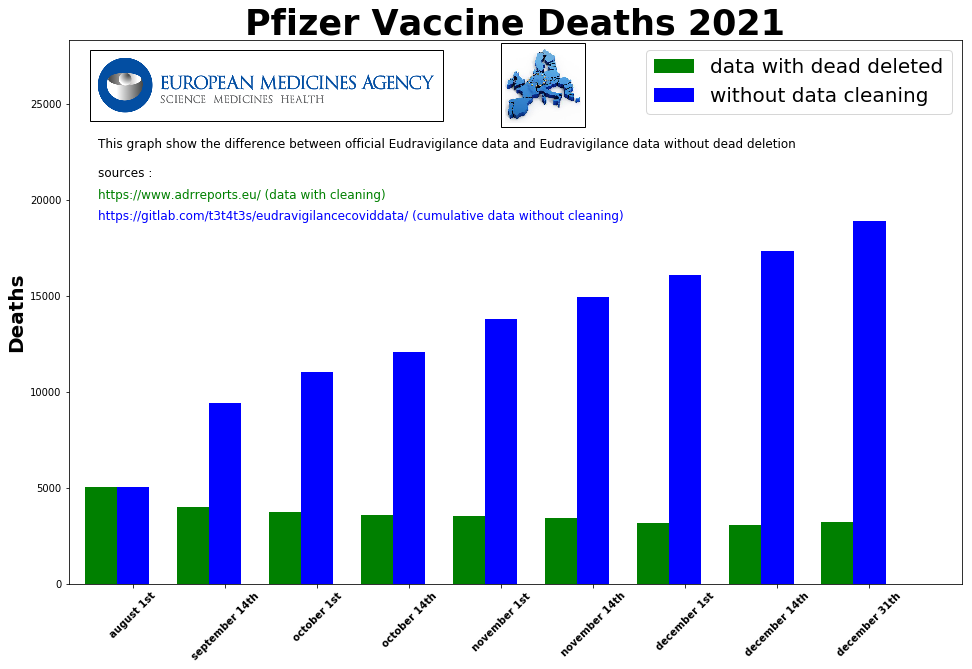

In [7]:
fig = plt.figure(figsize=(16,10),facecolor='white')
ax = fig.subplots()

## the data
N = len(dates)

## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, list_deaths, width, color='green')
rects2 = ax.bar(ind+width, list_cumul, width, color='blue')

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,max(list_cumul)*1.5)
ax.set_ylabel('Deaths',fontweight ='bold', fontsize = 20)
ax.set_title(vaccine + ' Vaccine Deaths ' + year,fontweight ='bold', fontsize = 35)
xTickMarks = dates_english
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontweight ='bold', fontsize=10)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('data with dead deleted', 'without data cleaning'), fontsize = 20 )

fig.text(0.15, 0.73,
         'This graph show the difference between official Eudravigilance data and Eudravigilance data without dead deletion', 
         fontsize = 12,
         color = "black")

fig.text(0.15, 0.69, 
         'sources :', 
         fontsize = 12,
         color = "black")

fig.text(0.15, 0.66,
         'https://www.adrreports.eu/ (data with cleaning)',
         fontsize = 12,
         color = "green")

fig.text(0.15, 0.63,
         'https://gitlab.com/t3t4t3s/eudravigilancecoviddata/ (cumulative data without cleaning)', 
         fontsize = 12,
         color = "blue")

arr_logo = mpimg.imread('logo_EMA.png')
imagebox1 = OffsetImage(arr_logo, zoom=0.5)
ab1 = AnnotationBbox(imagebox1, (1.8, max(list_cumul)*1.375))
ax.add_artist(ab1)

arr_EEE = mpimg.imread('carte_EEE.jpg')
imagebox2 = OffsetImage(arr_EEE, zoom=0.2)
ab2 = AnnotationBbox(imagebox2, (4.8, max(list_cumul)*1.375))
ax.add_artist(ab2)

fig.savefig("../resultats/" + year + "/all_ages/" + vaccine + "_cumulative_covid_vaccine_deaths_Europe_" + year + ".png")

plt.show()


### *Ib - Données Moderna*

In [8]:
vaccine = "Moderna"

In [9]:
list_delta_del = [0 for i in range(len(list_dates))]
list_delta_add = [0 for i in range(len(list_dates))]
list_deaths = [0 for i in range(len(list_dates))]
for date in range(len(list_dates)-1):
    nb_death_Moderna_before, nb_death_Moderna_after, nb_Moderna_deleted, nb_Moderna_added = calc_delta(list_dates[date], list_months[date], list_dates[date+1], list_months[date+1], year, 'MODERNA_CX-024414')
    list_deaths[date] = nb_death_Moderna_before
    list_deaths[date+1] = nb_death_Moderna_after
    list_delta_add[date+1] = nb_Moderna_added
    list_delta_del[date+1] = nb_Moderna_deleted
    print(nb_death_Moderna_before, nb_death_Moderna_after, nb_Moderna_deleted, nb_Moderna_added)

list_cumul = [0 for i in range(len(list_dates))]
list_cumul[0] = list_deaths[0]
for date in range(len(list_dates)-1):
    list_cumul[date+1] = list_cumul[date] + list_delta_del[date+1] + list_delta_add[date+1]
logs.append(
    {
        "vaccine":vaccine,
        "official_deaths":list_deaths[-1],
        "total_deaths":list_cumul[-1]
    }
)


3120 3535 103 518
3535 3777 44 286
3777 3980 19 222
3980 4279 24 323
4279 4476 14 211
4476 4605 18 147
4605 4791 18 204
4791 5098 16 323


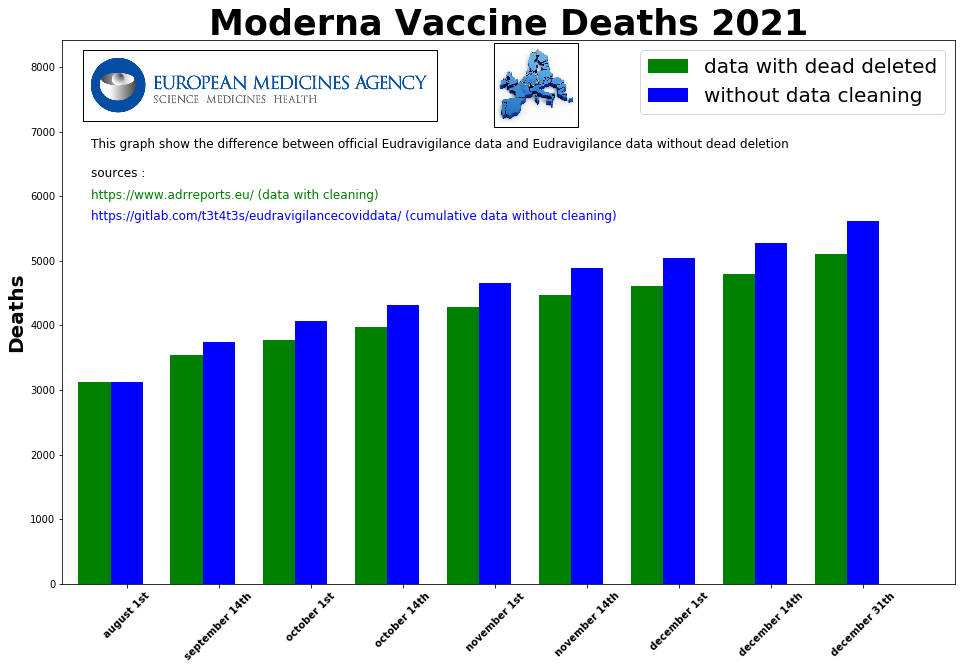

In [10]:
fig = plt.figure(figsize=(16,10),facecolor='white')
ax = fig.subplots()

## the data
N = len(dates)

## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, list_deaths, width, color='green')
rects2 = ax.bar(ind+width, list_cumul, width, color='blue')

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,max(list_cumul)*1.5)
ax.set_ylabel('Deaths',fontweight ='bold', fontsize = 20)
ax.set_title(vaccine + ' Vaccine Deaths ' + year,fontweight ='bold', fontsize = 35)
xTickMarks = dates_english
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontweight ='bold', fontsize=10)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('data with dead deleted', 'without data cleaning'), fontsize = 20 )

fig.text(0.15, 0.73,
         'This graph show the difference between official Eudravigilance data and Eudravigilance data without dead deletion', 
         fontsize = 12,
         color = "black")

fig.text(0.15, 0.69, 
         'sources :', 
         fontsize = 12,
         color = "black")

fig.text(0.15, 0.66,
         'https://www.adrreports.eu/ (data with cleaning)',
         fontsize = 12,
         color = "green")

fig.text(0.15, 0.63,
         'https://gitlab.com/t3t4t3s/eudravigilancecoviddata/ (cumulative data without cleaning)', 
         fontsize = 12,
         color = "blue")

arr_logo = mpimg.imread('logo_EMA.png')
imagebox1 = OffsetImage(arr_logo, zoom=0.5)
ab1 = AnnotationBbox(imagebox1, (1.8, max(list_cumul)*1.375))
ax.add_artist(ab1)

arr_EEE = mpimg.imread('carte_EEE.jpg')
imagebox2 = OffsetImage(arr_EEE, zoom=0.2)
ab2 = AnnotationBbox(imagebox2, (4.8, max(list_cumul)*1.375))
ax.add_artist(ab2)

fig.savefig("../resultats/" + year + "/all_ages/" + vaccine + "_cumulative_covid_vaccine_deaths_Europe_" + year + ".png")

plt.show()


### *Ic - Données Astrazeneca*

In [11]:
vaccine = "Astrazeneca"

In [12]:
list_delta_del = [0 for i in range(len(list_dates))]
list_delta_add = [0 for i in range(len(list_dates))]
list_deaths = [0 for i in range(len(list_dates))]
for date in range(len(list_dates)-1):
    nb_death_Astrazeneca_before, nb_death_Astrazeneca_after, nb_Astrazeneca_deleted, nb_Astrazeneca_added = calc_delta(list_dates[date], list_months[date], list_dates[date+1], list_months[date+1], year, 'ASTRAZENECA_CHADOX1-NCOV-19')
    list_deaths[date] = nb_death_Astrazeneca_before
    list_deaths[date+1] = nb_death_Astrazeneca_after
    list_delta_add[date+1] = nb_Astrazeneca_added
    list_delta_del[date+1] = nb_Astrazeneca_deleted
    print(nb_death_Astrazeneca_before, nb_death_Astrazeneca_after, nb_Astrazeneca_deleted, nb_Astrazeneca_added)

list_cumul = [0 for i in range(len(list_dates))]
list_cumul[0] = list_deaths[0]
for date in range(len(list_dates)-1):
    list_cumul[date+1] = list_cumul[date] + list_delta_del[date+1] + list_delta_add[date+1]
logs.append(
    {
        "vaccine":vaccine,
        "official_deaths":list_deaths[-1],
        "total_deaths":list_cumul[-1]
    }
)

2429 2777 218 566
2777 2815 111 149
2815 2894 76 155
2894 2944 141 191
2944 3014 68 138
3014 3185 122 293
3185 3275 88 178
3275 3629 137 491


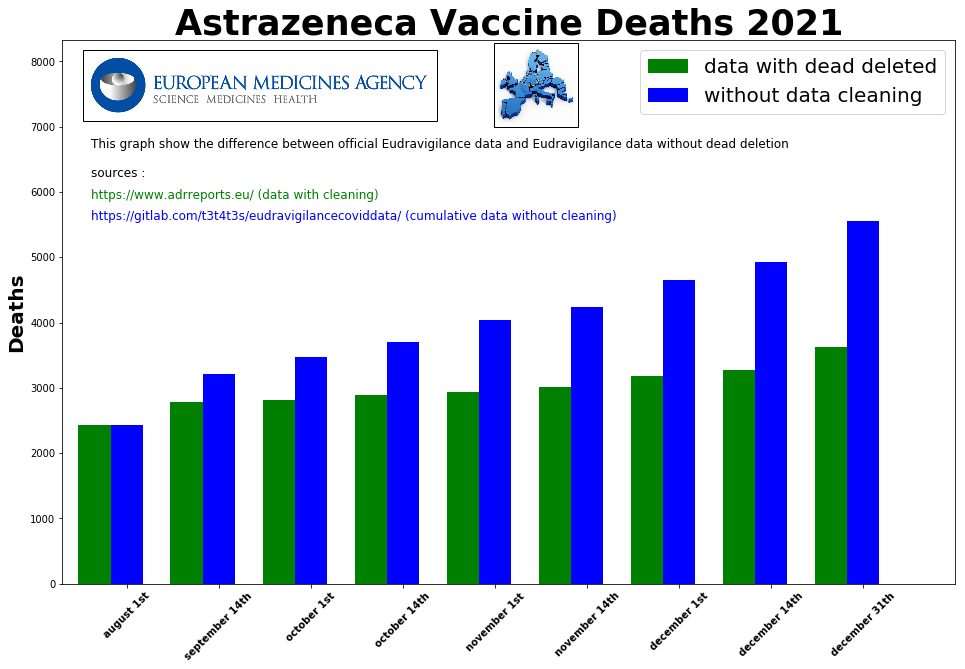

In [13]:
fig = plt.figure(figsize=(16,10),facecolor='white')
ax = fig.subplots()

## the data
N = len(dates)

## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, list_deaths, width, color='green')
rects2 = ax.bar(ind+width, list_cumul, width, color='blue')

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,max(list_cumul)*1.5)
ax.set_ylabel('Deaths',fontweight ='bold', fontsize = 20)
ax.set_title(vaccine + ' Vaccine Deaths ' + year,fontweight ='bold', fontsize = 35)
xTickMarks = dates_english
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontweight ='bold', fontsize=10)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('data with dead deleted', 'without data cleaning'), fontsize = 20 )

fig.text(0.15, 0.73,
         'This graph show the difference between official Eudravigilance data and Eudravigilance data without dead deletion', 
         fontsize = 12,
         color = "black")

fig.text(0.15, 0.69, 
         'sources :', 
         fontsize = 12,
         color = "black")

fig.text(0.15, 0.66,
         'https://www.adrreports.eu/ (data with cleaning)',
         fontsize = 12,
         color = "green")

fig.text(0.15, 0.63,
         'https://gitlab.com/t3t4t3s/eudravigilancecoviddata/ (cumulative data without cleaning)', 
         fontsize = 12,
         color = "blue")

arr_logo = mpimg.imread('logo_EMA.png')
imagebox1 = OffsetImage(arr_logo, zoom=0.5)
ab1 = AnnotationBbox(imagebox1, (1.8, max(list_cumul)*1.375))
ax.add_artist(ab1)

arr_EEE = mpimg.imread('carte_EEE.jpg')
imagebox2 = OffsetImage(arr_EEE, zoom=0.2)
ab2 = AnnotationBbox(imagebox2, (4.8, max(list_cumul)*1.375))
ax.add_artist(ab2)

fig.savefig("../resultats/" + year + "/all_ages/" + vaccine + "_cumulative_covid_vaccine_deaths_Europe_" + year + ".png")

plt.show()


### *Id - Données Janssen*

In [14]:
vaccine = "Janssen"

In [15]:
list_delta_del = [0 for i in range(len(list_dates))]
list_delta_add = [0 for i in range(len(list_dates))]
list_deaths = [0 for i in range(len(list_dates))]
for date in range(len(list_dates)-1):
    nb_death_Janssen_before, nb_death_Janssen_after, nb_Janssen_deleted, nb_Janssen_added = calc_delta(list_dates[date], list_months[date], list_dates[date+1], list_months[date+1], year, 'JANSSEN_AD26.COV2.S')
    list_deaths[date] = nb_death_Janssen_before
    list_deaths[date+1] = nb_death_Janssen_after
    list_delta_add[date+1] = nb_Janssen_added
    list_delta_del[date+1] = nb_Janssen_deleted
    print(nb_death_Janssen_before, nb_death_Janssen_after, nb_Janssen_deleted, nb_Janssen_added)

list_cumul = [0 for i in range(len(list_dates))]
list_cumul[0] = list_deaths[0]
for date in range(len(list_dates)-1):
    list_cumul[date+1] = list_cumul[date] + list_delta_del[date+1] + list_delta_add[date+1]
logs.append(
    {
        "vaccine":vaccine,
        "official_deaths":list_deaths[-1],
        "total_deaths":list_cumul[-1]
    }
)

315 544 30 259
544 578 34 68
578 658 16 96
658 745 21 108
745 830 25 110
830 885 37 92
885 922 15 52
922 1038 36 152


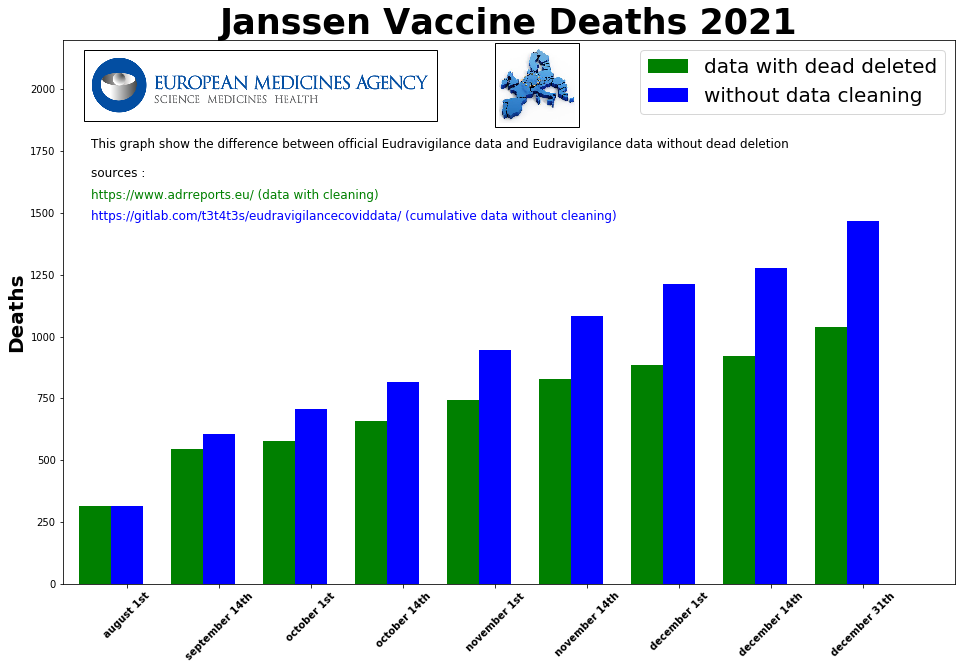

In [16]:
fig = plt.figure(figsize=(16,10),facecolor='white')
ax = fig.subplots()

## the data
N = len(dates)

## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, list_deaths, width, color='green')
rects2 = ax.bar(ind+width, list_cumul, width, color='blue')

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,max(list_cumul)*1.5)
ax.set_ylabel('Deaths',fontweight ='bold', fontsize = 20)
ax.set_title(vaccine + ' Vaccine Deaths ' + year,fontweight ='bold', fontsize = 35)
xTickMarks = dates_english
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontweight ='bold', fontsize=10)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('data with dead deleted', 'without data cleaning'), fontsize = 20 )

fig.text(0.15, 0.73,
         'This graph show the difference between official Eudravigilance data and Eudravigilance data without dead deletion', 
         fontsize = 12,
         color = "black")

fig.text(0.15, 0.69, 
         'sources :', 
         fontsize = 12,
         color = "black")

fig.text(0.15, 0.66,
         'https://www.adrreports.eu/ (data with cleaning)',
         fontsize = 12,
         color = "green")

fig.text(0.15, 0.63,
         'https://gitlab.com/t3t4t3s/eudravigilancecoviddata/ (cumulative data without cleaning)', 
         fontsize = 12,
         color = "blue")

arr_logo = mpimg.imread('logo_EMA.png')
imagebox1 = OffsetImage(arr_logo, zoom=0.5)
ab1 = AnnotationBbox(imagebox1, (1.8, max(list_cumul)*1.375))
ax.add_artist(ab1)

arr_EEE = mpimg.imread('carte_EEE.jpg')
imagebox2 = OffsetImage(arr_EEE, zoom=0.2)
ab2 = AnnotationBbox(imagebox2, (4.8, max(list_cumul)*1.375))
ax.add_artist(ab2)

fig.savefig("../resultats/" + year + "/all_ages/" + vaccine + "_cumulative_covid_vaccine_deaths_Europe_" + year + ".png")

plt.show()


## *II - Sauvegarde des données*

In [17]:
# Configuration du fichier .csv de sauvegarde
exportFilename = "../resultats/" + year + "/all_ages/covid_vaccine_deaths_" + year + ".csv"

# csv header
fieldnames = ['vaccine', 'official_deaths', 'total_deaths']

with open(exportFilename, 'w', encoding='UTF8', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(logs)